In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Data Loader

In [4]:
df_ny = pd.read_csv('../data/processed/ny.csv')
df_aus = pd.read_csv('../data/processed/austin.csv')
df = pd.read_csv('../data/processed/combined_data.csv')

# Display the combined DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26200 entries, 0 to 26199
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26200 non-null  object 
 1   grid          26200 non-null  float64
 2   bathroom      26200 non-null  float64
 3   bedroom       26200 non-null  float64
 4   car           26200 non-null  float64
 5   diningroom    26200 non-null  float64
 6   livingroom    26200 non-null  float64
 7   office        26200 non-null  float64
 8   utilityroom   26200 non-null  float64
 9   waterheater   26200 non-null  float64
 10  aircomp       26200 non-null  float64
 11  kitchenArea   26200 non-null  float64
 12  washer_dryer  26200 non-null  float64
 13  other         26200 non-null  float64
 14  day           26200 non-null  object 
 15  month         26200 non-null  object 
 16  day_name      26200 non-null  object 
 17  hour          26200 non-null  int64  
 18  minute        26200 non-nu

## Fix Data Types

In [5]:
# Define a function to convert data types
def convert_data_types(df):
    # Convert 'date' column to datetime if it exists
    if 'date' in df.columns and df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        
    if 'day' in df.columns and df['day'].dtype == 'object':
        df['day'] = pd.to_datetime(df['day'], errors='coerce')
    
    # Convert all other object columns to categorical
    for column in df.select_dtypes(include='object').columns:
        df[column] = df[column].astype('category')
    
    return df

# Define the correct order for months and days
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_of_day_order = ['Night', 'Morning', 'Afternoon', 'Evening']

# Define a function to convert data types and set categorical order
def convert_and_order_categories(df):
    # Convert 'date' column to datetime if it exists
    if 'date' in df.columns and df['date'].dtype == 'object':
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert categorical columns with explicit ordering
    if 'month' in df.columns:
        df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
    if 'day_name' in df.columns:
        df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)
    if 'time_of_day' in df.columns:
        df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=time_of_day_order, ordered=True)
    
    # Convert remaining object columns to category without specific ordering
    for column in df.select_dtypes(include='object').columns:
        if column not in ['month', 'day_name', 'time_of_day']:  # Exclude already converted columns
            df[column] = df[column].astype('category')
    
    return df



In [6]:
# Apply the function to both DataFrames
df = convert_data_types(df)

df = convert_and_order_categories(df)


# ML Prediction

### Individal Model

In [44]:
# Global settings
max_iter = 10  # Maximum number of iterations for RandomizedSearchCV
cv_folds = 5  # Number of cross-validation folds

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define MAPE scorer for RandomizedSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Function to plot actual vs predicted values for both train and test sets
def plot_train_vs_test(y_train, y_train_pred, y_test, y_test_pred, model_name):
    plt.figure(figsize=(12, 6))

    # Plot for training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Train: Actual vs Predicted ({model_name})")
    plt.legend()

    # Plot for test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color="green", label="Predicted vs Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Test: Actual vs Predicted ({model_name})")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to prepare the data with preprocessing (OneHotEncoding, Scaling)
def prepare_data(df, target_column, feature_columns=None):
    # Prepare the features (X) and target (y)
    X = df[feature_columns]
    y = df[target_column].values

    # Define categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Create a preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),   # Scale numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)   # One-hot encode categorical features, ignoring unknown categories
        ]
    )

    # Apply transformations to the features
    X_preprocessed = preprocessor.fit_transform(X)

    # Split the data randomly into train (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

# Function to evaluate models using RandomizedSearchCV for hyperparameter optimization
def evaluate_models(X_train, y_train, X_test, y_test):
    # Initialize base regression models and hyperparameter search space
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': None  # No hyperparameter tuning for LinearRegression
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42, n_jobs=-1),
            'params': {
                'n_estimators':[50, 100, 200, 300],
                'max_depth': [5, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5]
            }
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.1, 0.3],
                'min_child_weight': [1, 5, 10],
                'subsample': [0.5, 0.7, 1.0],
                'colsample_bytree': [0.5, 0.7, 1.0]
            },
            'early_stopping': True  # Flag to apply early stopping for this model
        }
    }
    

    # List to store the results for each model
    results = []

    # Loop through models and perform training and evaluation
    for model_name, model_info in models.items():
        model = model_info['model']
        params = model_info['params']

        if params is not None:
            # If hyperparameters are provided, use RandomizedSearchCV
            optimizer = RandomizedSearchCV(model, params, n_iter=max_iter, cv=cv_folds, random_state=42, scoring='r2', n_jobs=-1)
            optimizer.fit(X_train, y_train)
            best_model = optimizer.best_estimator_
        else:
            # No hyperparameter tuning (e.g., LinearRegression)
            best_model = model
            best_model.fit(X_train, y_train)

        # Predict on train and test sets
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Plot actual vs predicted for both train and test sets
        plot_train_vs_test(y_train, y_train_pred, y_test, y_test_pred, model_name)

        # Calculate evaluation metrics for train set
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)

        # Calculate evaluation metrics for test set
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Store the results in a dictionary for both train and test sets
        results.append({
            'Model': model_name,
            'Train_MAE': mae_train,
            'Train_MAPE (%)': mape_train,
            'Train_R2': r2_train,
            'Test_MAE': mae_test,
            'Test_MAPE (%)': mape_test,
            'Test_R2': r2_test
        })

    # Convert the results list into a DataFrame
    ML_result_df = pd.DataFrame(results)

    return ML_result_df


Evaluating models for Austin dataset


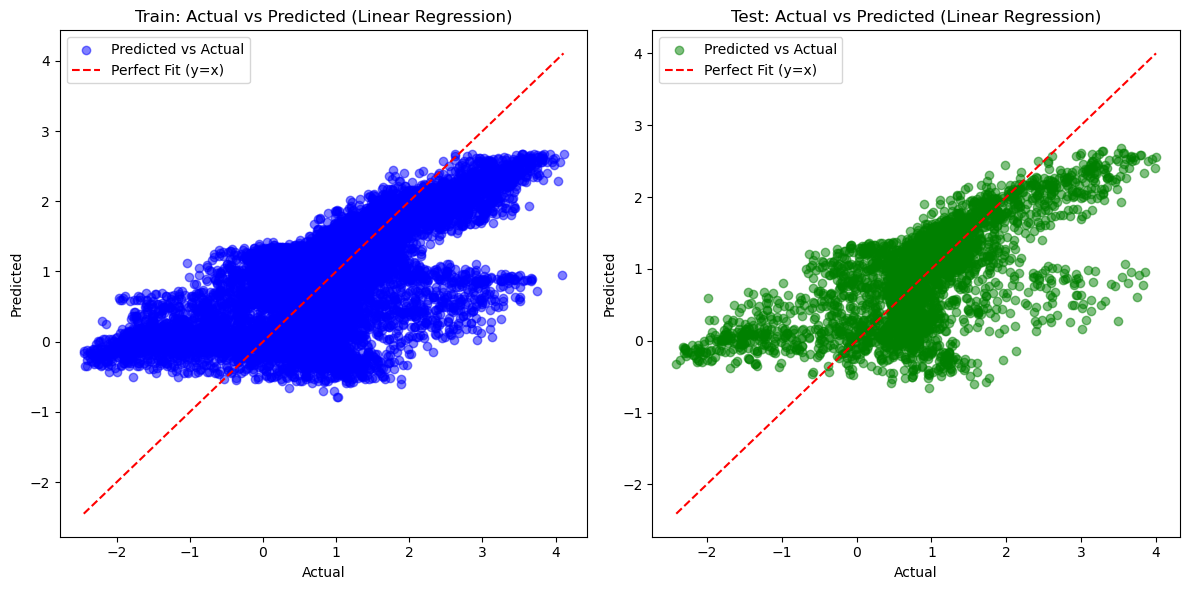

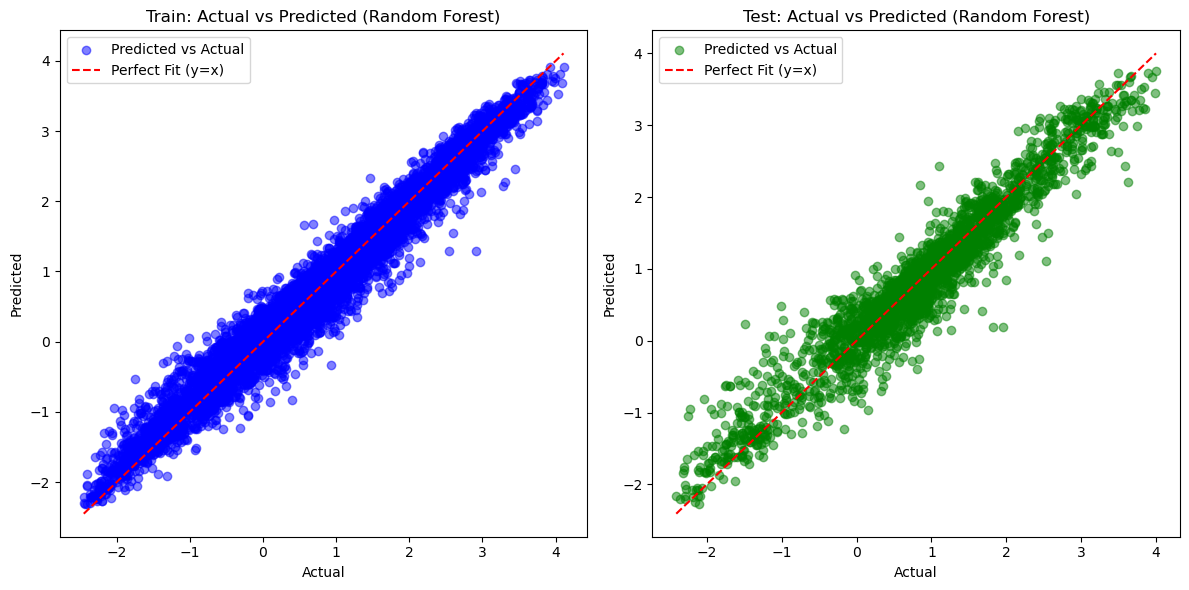

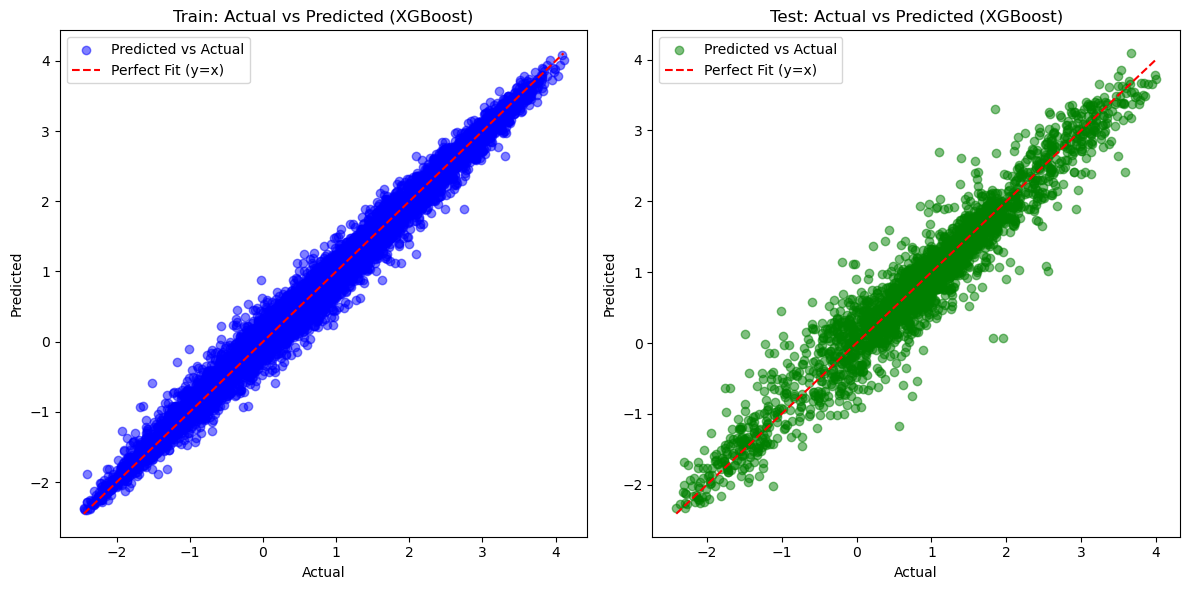

Results for Austin dataset:


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.563242,172.544033,0.442784,0.556213,218.123624,0.436489
1,Random Forest,0.138982,51.061907,0.962833,0.198873,105.986454,0.921369
2,XGBoost,0.098595,37.158369,0.982073,0.194441,130.608776,0.924152



--------------------------------------------------

Evaluating models for NY dataset


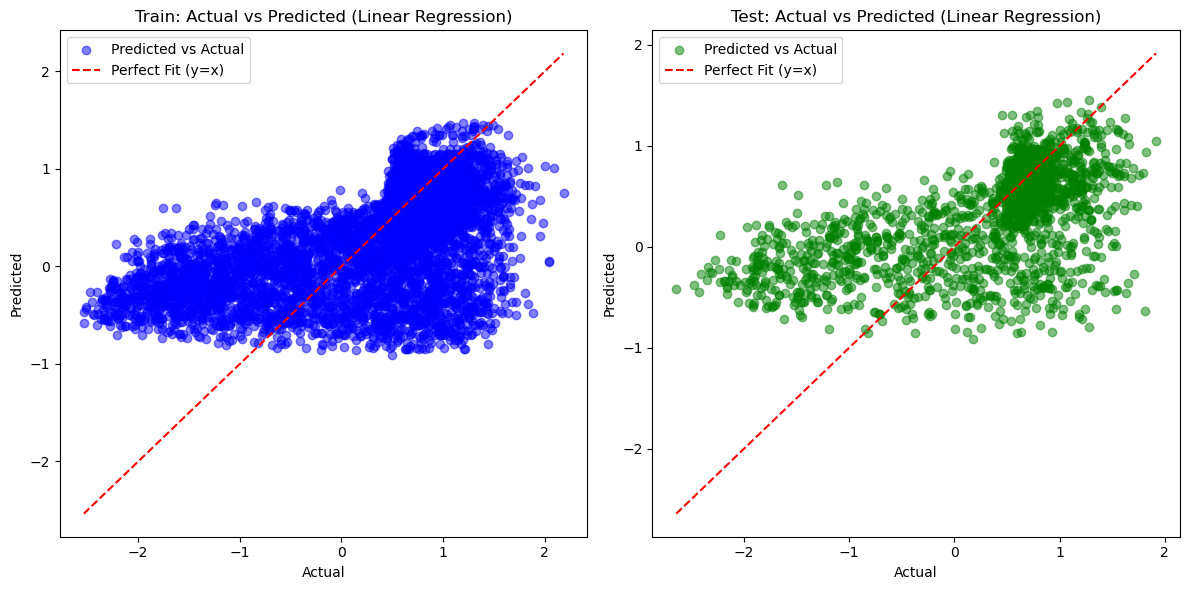

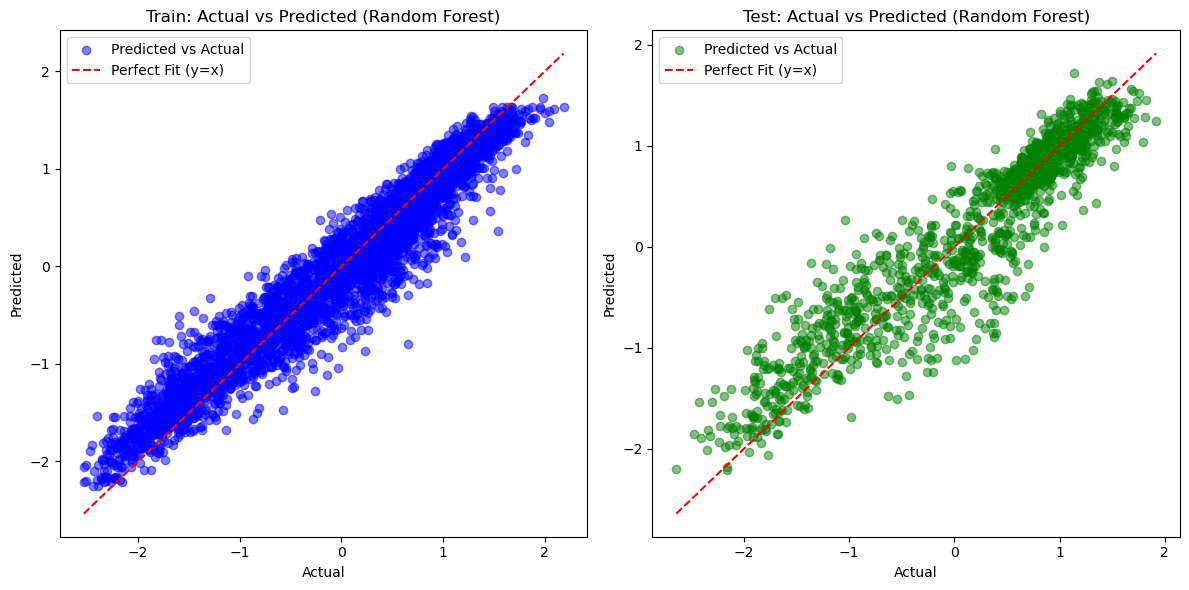

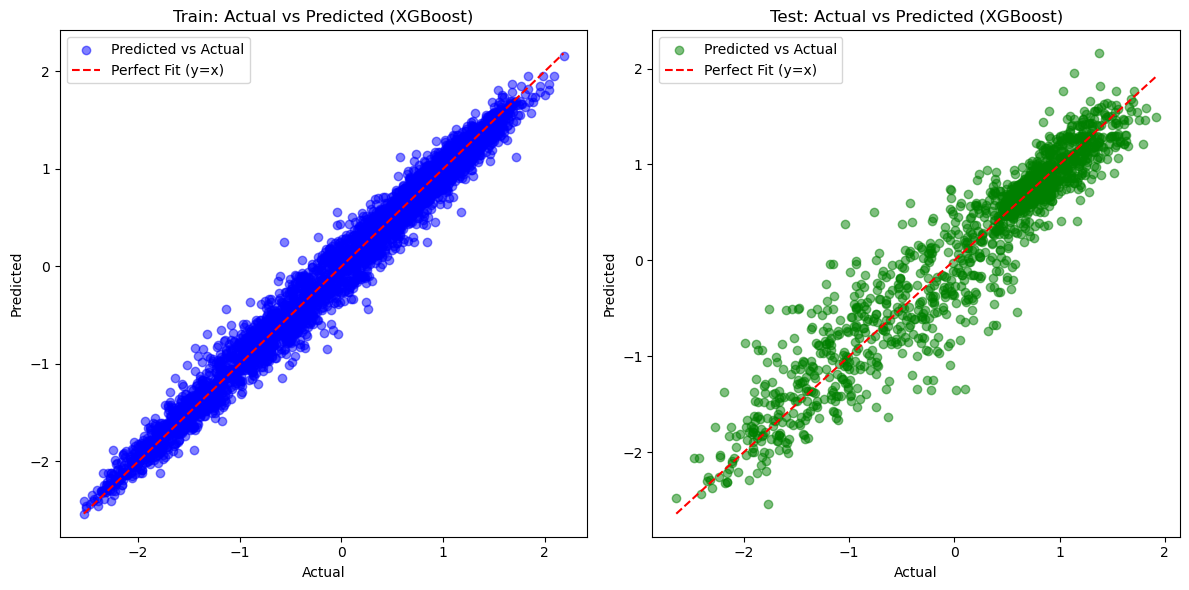

Results for NY dataset:


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.553172,164.282125,0.295797,0.558507,124.938252,0.314711
1,Random Forest,0.148646,129.046144,0.941800,0.216366,81.228770,0.879380
2,XGBoost,0.080740,44.486467,0.983483,0.196105,95.603161,0.902709



--------------------------------------------------



In [46]:
# Define the list of datasets
datasets = {'Austin': df_aus, 'NY': df_ny}  # Add your datasets with descriptive names

# Define feature columns and target
feature_columns = ['month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']
target = 'grid'

# Loop through each dataset, prepare the data, and evaluate models
for name, df in datasets.items():
    print(f"Evaluating models for {name} dataset")
    
    # Prepare the data
    X_train, y_train, X_test, y_test = prepare_data(df, target_column=target, feature_columns=feature_columns)
    
    # Evaluate models and display the results
    results = evaluate_models(X_train, y_train, X_test, y_test)
    
    # Display results with a title for clarity
    print(f"Results for {name} dataset:")
    display(results)
    print("\n" + "-"*50 + "\n")

### NN

Processing dataset: Austin
Epoch 1/100
435/435 [==============================] - 1s 1ms/step - loss: 0.3474 - mae: 0.4080 - val_loss: 0.1613 - val_mae: 0.2890
Epoch 2/100
435/435 [==============================] - 0s 1ms/step - loss: 0.1521 - mae: 0.2822 - val_loss: 0.1370 - val_mae: 0.2696
Epoch 3/100
435/435 [==============================] - 0s 1ms/step - loss: 0.1289 - mae: 0.2588 - val_loss: 0.1408 - val_mae: 0.2653
Epoch 4/100
435/435 [==============================] - 0s 928us/step - loss: 0.1187 - mae: 0.2491 - val_loss: 0.1110 - val_mae: 0.2394
Epoch 5/100
435/435 [==============================] - 0s 983us/step - loss: 0.1093 - mae: 0.2388 - val_loss: 0.1140 - val_mae: 0.2388
Epoch 6/100
435/435 [==============================] - 0s 916us/step - loss: 0.1049 - mae: 0.2338 - val_loss: 0.1016 - val_mae: 0.2279
Epoch 7/100
435/435 [==============================] - 0s 908us/step - loss: 0.1029 - mae: 0.2308 - val_loss: 0.1055 - val_mae: 0.2301
Epoch 8/100
435/435 [=============

,Dataset,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Austin,0.203388,67.109211,0.925532,0.22096,132.024827,0.908051


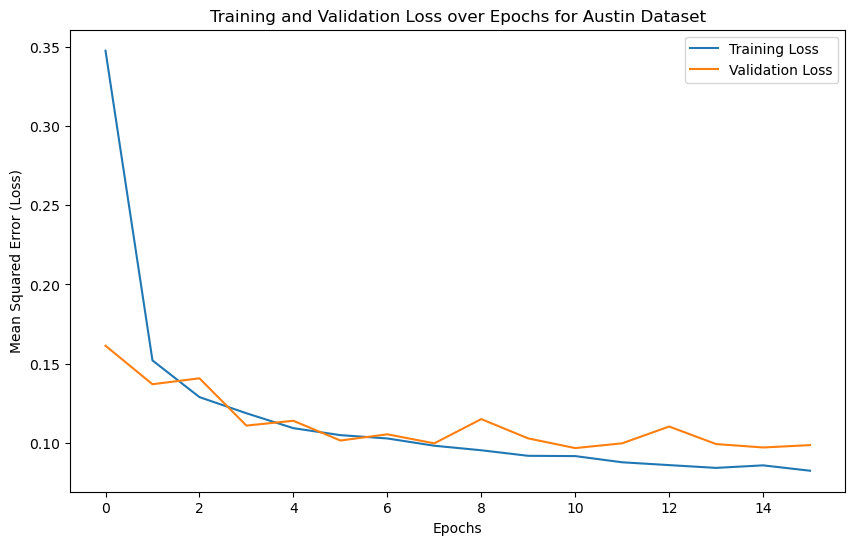

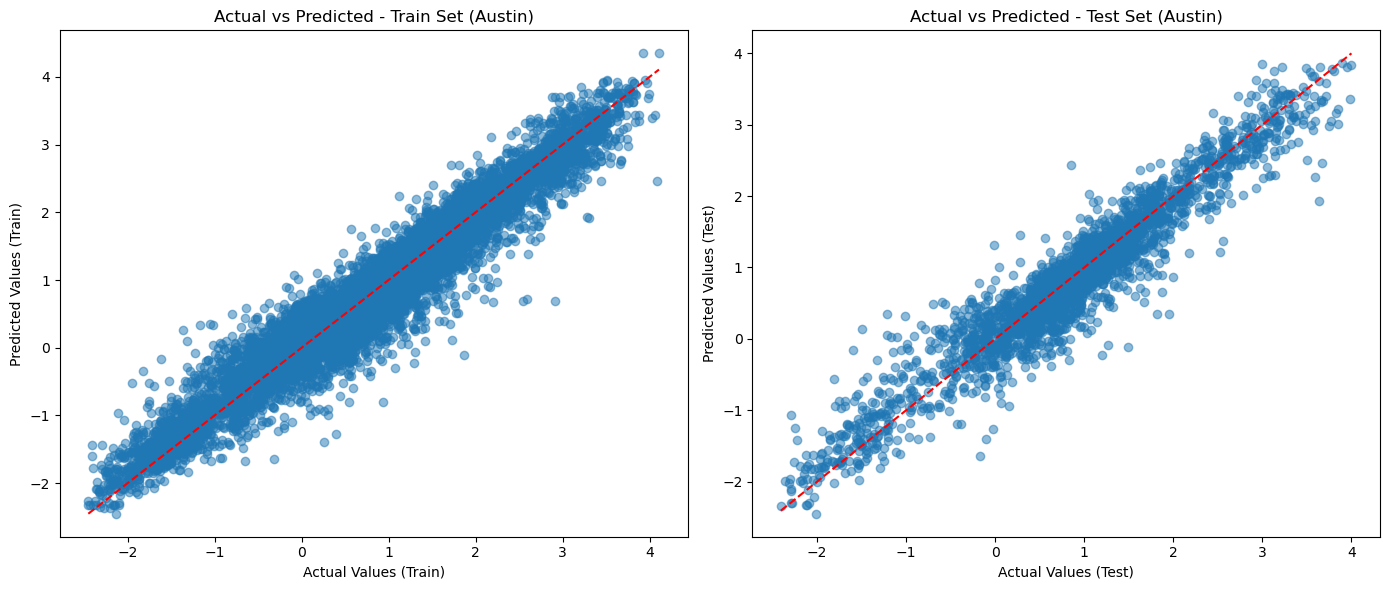

Processing dataset: NY
Epoch 1/100
221/221 [==============================] - 1s 2ms/step - loss: 0.3832 - mae: 0.4456 - val_loss: 0.2250 - val_mae: 0.3456
Epoch 2/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1952 - mae: 0.3158 - val_loss: 0.1920 - val_mae: 0.3269
Epoch 3/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1641 - mae: 0.2890 - val_loss: 0.1643 - val_mae: 0.2917
Epoch 4/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1481 - mae: 0.2729 - val_loss: 0.1526 - val_mae: 0.2797
Epoch 5/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1333 - mae: 0.2575 - val_loss: 0.1468 - val_mae: 0.2690
Epoch 6/100
221/221 [==============================] - 0s 1ms/step - loss: 0.1246 - mae: 0.2485 - val_loss: 0.1453 - val_mae: 0.2633
Epoch 7/100
221/221 [==============================] - 0s 957us/step - loss: 0.1218 - mae: 0.2425 - val_loss: 0.1206 - val_mae: 0.2453
Epoch 8/100
221/221 [=======================

,Dataset,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,NY,0.190616,125.084729,0.909307,0.215144,82.575134,0.886741


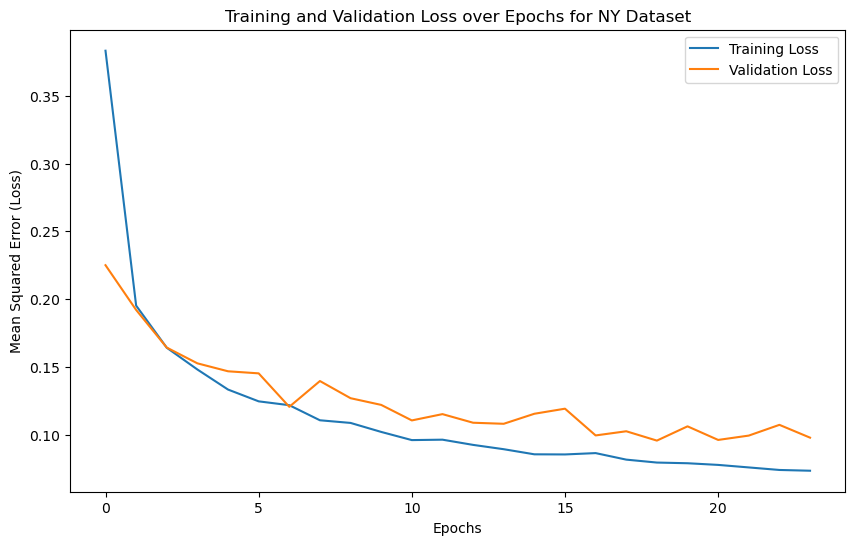

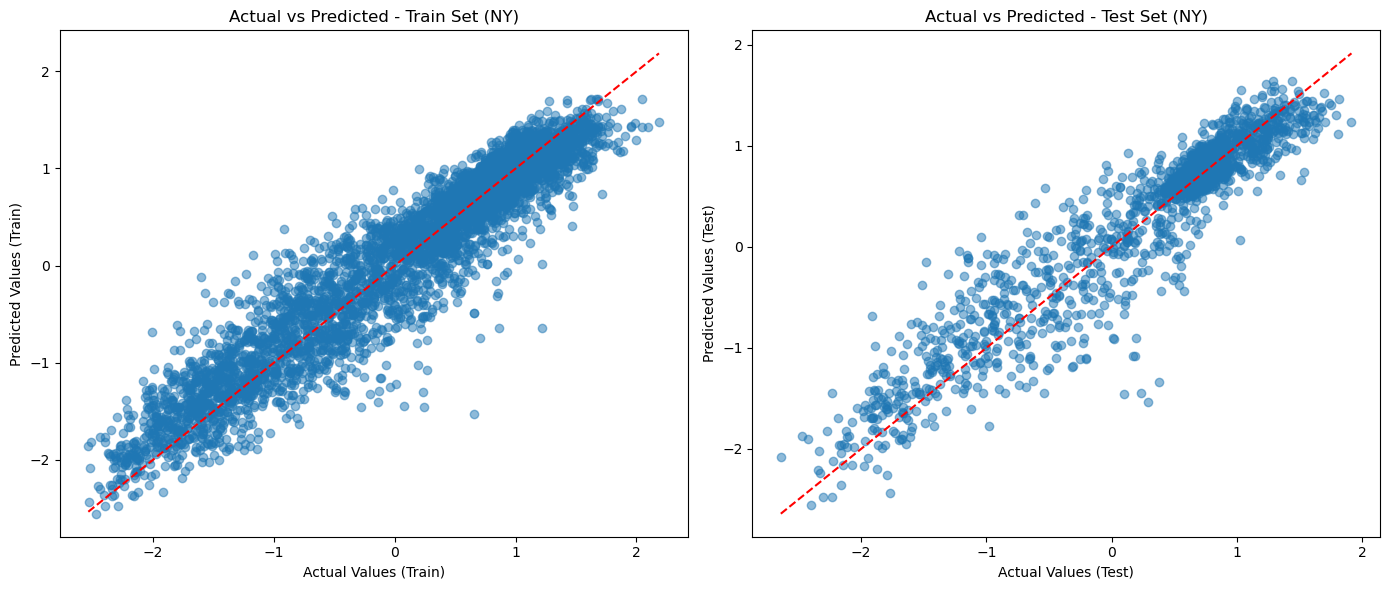

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the list of datasets
datasets = {'Austin': df_aus, 'NY': df_ny}  # Add your datasets with descriptive names

# Define feature columns and target
feature_columns = ['month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']
target = 'grid'

# Loop through each dataset
for name, df in datasets.items():
    print(f"Processing dataset: {name}")

    # Splitting the data into features (X) and target (y)
    X = df[feature_columns]
    y = df[target]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing pipeline for feature columns
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(sparse_output=False), categorical_features)
        ]
    )

    # Creating a preprocessing and modeling pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Preprocess the data
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)

    # Ensure y_train and y_test are numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Building the Neural Network model
    model = Sequential([
        Dense(128, input_dim=X_train_processed.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compiling the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Adding early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training the model
    history = model.fit(X_train_processed, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test_processed, y_test), callbacks=[early_stop])

    # Evaluating the model
    y_train_pred = model.predict(X_train_processed)
    y_test_pred = model.predict(X_test_processed)

    # Calculating metrics with sklearn
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    test_r2 = r2_score(y_test, y_test_pred)

    # Creating a result table
    results = pd.DataFrame({
        'Dataset': [name],
        'Train_MAE': [train_mae],
        'Train_MAPE (%)': [train_mape],
        'Train_R2': [train_r2],
        'Test_MAE': [test_mae],
        'Test_MAPE (%)': [test_mape],
        'Test_R2': [test_r2]
    })

    # Displaying results for the current dataset
    print(f"Results for {name} dataset:")
    display(results)

    # Plotting the loss function over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Loss)')
    plt.title(f'Training and Validation Loss over Epochs for {name} Dataset')
    plt.legend()
    plt.show()

    # Plotting Actual vs Predicted for Train and Test sets
    plt.figure(figsize=(14, 6))

    # Train set plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Values (Train)')
    plt.ylabel('Predicted Values (Train)')
    plt.title(f'Actual vs Predicted - Train Set ({name})')

    # Test set plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values (Test)')
    plt.ylabel('Predicted Values (Test)')
    plt.title(f'Actual vs Predicted - Test Set ({name})')

    plt.tight_layout()
    plt.show()

### Evaluate Multi-DF

In [128]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import joblib
from IPython.display import display

# Global settings
max_iter = 10  # Maximum number of iterations for RandomizedSearchCV
cv_folds = 5  # Number of cross-validation folds
base_model_save_path = '../models/energy_consumption'  # Base directory to save models

# Ensure the base model save directory exists
os.makedirs(base_model_save_path, exist_ok=True)

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define MAPE scorer for RandomizedSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Function to plot and save actual vs predicted values for both train and test sets for the best model only
def plot_best_model(y_train, y_train_pred, y_test, y_test_pred, model_name, target_name, city_name, model_save_path):
    plt.figure(figsize=(12, 6))

    # Plot for training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, color="blue", label="Predicted vs Actual")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Train: Actual vs Predicted ({model_name}) - {target_name}")
    plt.legend()

    # Plot for test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5, color="green", label="Predicted vs Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Fit (y=x)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Test: Actual vs Predicted ({model_name}) - {target_name}")
    plt.legend()

    plt.tight_layout()
    
    # Save the plot as a PNG file
    plot_filename = f"{model_save_path}/best_model_plot_{target_name}.png"
    plt.savefig(plot_filename)  # Save the plot as a PNG file
    plt.close()
    print(f"Plot for best model of {city_name} - {target_name} saved as {plot_filename}")
    
    # Display the plot
    plt.show()

# Function to prepare the data with preprocessing (OneHotEncoding, Scaling)
def prepare_data(df, target_column, feature_columns):
    # Prepare the features (X) and target (y)
    X = df[feature_columns]
    y = df[target_column].values

    # Define categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Create a preprocessor pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),   # Scale numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)   # One-hot encode categorical features, ignoring unknown categories
        ]
    )

    # Apply transformations to the features
    X_preprocessed = preprocessor.fit_transform(X)

    # Split the data randomly into train (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

# Function to evaluate models using RandomizedSearchCV for hyperparameter optimization
def evaluate_models(X_train, y_train, X_test, y_test, target_name, city_name):
    print(f"\nEvaluating models for City: {city_name}, Target: {target_name}")
    
    # Initialize base regression models and hyperparameter search space
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': None  # No hyperparameter tuning for LinearRegression
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42, bootstrap=True, oob_score=True, n_jobs=-1),
            'params': {
                'n_estimators': [25, 50, 100, 200],
                'max_depth': [3, 5, 10, 15],
                'min_samples_split': [2, 5, 8],
                'min_samples_leaf': [1, 2, 5]
            }
        },
        'XGBoost': {
            'model': XGBRegressor(random_state=42, early_stopping_rounds=10),  # Specify early stopping here
            'params': {
                'n_estimators': [25, 50, 100, 200],
                'max_depth': [3, 5, 10],
                'learning_rate': [0.01, 0.1],
                'min_child_weight': [1, 5, 10],
                'subsample': [0.5, 0.8],
                'colsample_bytree': [0.5, 0.7, 1.0]
            }
        }
    }

    best_overall_model = None
    best_overall_score = -np.inf
    results = []

    # Create a subfolder for each city and target (appliance)
    model_save_path = f"{base_model_save_path}/{city_name}/{target_name}"
    os.makedirs(model_save_path, exist_ok=True)

    # Split X_train into train and validation sets for early stopping
    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Loop through models and perform training and evaluation
    for model_name, model_info in models.items():
        model = model_info['model']
        params = model_info['params']

        if model_name == 'XGBoost':
            # Use eval_set for early stopping
            optimizer = RandomizedSearchCV(
                model, params, n_iter=max_iter, cv=cv_folds, random_state=42,
                scoring='r2', n_jobs=-1
            )
            optimizer.fit(
                X_train_part, y_train_part,
                eval_set=[(X_val, y_val)],  # Validation set for early stopping
                verbose=False
            )
            best_model = optimizer.best_estimator_

        elif params is not None:
            optimizer = RandomizedSearchCV(model, params, n_iter=max_iter, cv=cv_folds, random_state=42, scoring='r2', n_jobs=-1)
            optimizer.fit(X_train, y_train)
            best_model = optimizer.best_estimator_
        
        else:
            best_model = model
            best_model.fit(X_train, y_train)

        # Predictions and evaluations
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Store results
        results.append({
            'Model': model_name,
            'Train_MAE': round(mae_train, 2),
            'Train_MAPE (%)': round(mape_train, 2),
            'Train_R2': round(r2_train, 2),
            'Test_MAE': round(mae_test, 2),
            'Test_MAPE (%)': round(mape_test, 2),
            'Test_R2': round(r2_test, 2)
        })

        if r2_test > best_overall_score:
            best_overall_score = r2_test
            best_overall_model = best_model
            y_train_best, y_test_best = y_train_pred, y_test_pred

    # Plot and save the best model predictions
    plot_best_model(y_train, y_train_best, y_test, y_test_best, best_overall_model.__class__.__name__, target_name, city_name, model_save_path)

    # Save the best model
    best_model_filename = f"{model_save_path}/best_model_{target_name}.joblib"
    joblib.dump(best_overall_model, best_model_filename)
    print(f"Best model for {city_name} - {target_name} saved as {best_model_filename}")

    # Summary DataFrame
    model_summary_df = pd.DataFrame(results, columns=['Model', 'Train_MAE', 'Train_MAPE (%)', 'Train_R2', 'Test_MAE', 'Test_MAPE (%)', 'Test_R2'])
    summary_filename = f"{model_save_path}/model_summary_{target_name}.csv"
    model_summary_df.to_csv(summary_filename, index=False)
    display(model_summary_df)

    return model_summary_df, best_overall_model.__class__.__name__

# Loop through each city and target, and run model training and evaluation
def run_model_per_city(dfs, targets):
    all_best_models_summary = []  # To store best models for each city and target
    for city_name, city_info in dfs.items():
        df = city_info['data']
        features = city_info['features']
        best_models_summary = []
        
        for target_name in targets:
            if features:
                X_train, y_train, X_test, y_test = prepare_data(df, target_name, features)
                summary_df, best_model_name = evaluate_models(X_train, y_train, X_test, y_test, target_name, city_name)
                best_models_summary.append({
                    'DataFrame_Name': city_name,
                    'Target': target_name,
                    'Best_Model': best_model_name,
                    'Test_R2': summary_df['Test_R2'].max()
                })

        # Display summary table of best models for each appliance in this city
        best_models_summary_df = pd.DataFrame(best_models_summary)
        print(f"\nBest Models Summary for City: {city_name}\n")
        display(best_models_summary_df)
        
        # Add the current city's best models to the combined summary
        all_best_models_summary.extend(best_models_summary)

    # If more than one city, display a combined summary table for all cities
    if len(dfs) > 1:
        combined_best_models_summary_df = pd.DataFrame(all_best_models_summary)
        print("\nCombined Best Models Summary for All Cities\n")
        display(combined_best_models_summary_df)
        
        combined_best_models_summary_df.to_csv('../models/energy_consumption/models_summary.csv')
        

In [129]:
features_city = ['month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']
features_multi = ['city','month', 'day_name', 'hour', 'season','is_holiday', 'temp', 'rhum', 'wspd']


dfs = {
    'Austin': {'data': df_aus, 'features': features_city},
    'NY': {'data': df_ny, 'features': features_city},
    'Multi_city': {'data': df, 'features': features_multi}
}

# Target columns to predict
target_columns = ['grid', 'bathroom', 'bedroom', 'car', 'diningroom','livingroom', 'office', 'utilityroom', 'waterheater', 'aircomp','kitchenArea', 'washer_dryer', 'other']

run_model_per_city(dfs, target_columns)


Evaluating models for City: Austin, Target: grid
Plot for best model of Austin - grid saved as ../models/energy_consumption/Austin/grid/best_model_plot_grid.png
Best model for Austin - grid saved as ../models/energy_consumption/Austin/grid/best_model_grid.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.56,172.54,0.44,0.56,218.12,0.44
1,Random Forest,0.15,57.42,0.95,0.21,112.67,0.91
2,XGBoost,0.14,47.94,0.96,0.20,113.54,0.92



Evaluating models for City: Austin, Target: bathroom
Plot for best model of Austin - bathroom saved as ../models/energy_consumption/Austin/bathroom/best_model_plot_bathroom.png
Best model for Austin - bathroom saved as ../models/energy_consumption/Austin/bathroom/best_model_bathroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,65.62,0.18,0.0,66.35,0.19
1,Random Forest,0.0,33.05,0.75,0.0,48.08,0.47
2,XGBoost,0.0,38.74,0.70,0.0,50.19,0.45



Evaluating models for City: Austin, Target: bedroom
Plot for best model of Austin - bedroom saved as ../models/energy_consumption/Austin/bedroom/best_model_plot_bedroom.png
Best model for Austin - bedroom saved as ../models/energy_consumption/Austin/bedroom/best_model_bedroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.01,24.44,0.28,0.01,24.65,0.29
1,Random Forest,0.00,10.35,0.85,0.00,13.92,0.73
2,XGBoost,0.00,6.46,0.92,0.00,11.60,0.79



Evaluating models for City: Austin, Target: car


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1

Plot for best model of Austin - car saved as ../models/energy_consumption/Austin/car/best_model_plot_car.png
Best model for Austin - car saved as ../models/energy_consumption/Austin/car/best_model_car.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.07,inf,0.09,0.07,inf,0.11
1,Random Forest,0.03,inf,0.74,0.05,inf,0.56
2,XGBoost,0.02,inf,0.85,0.04,inf,0.60



Evaluating models for City: Austin, Target: diningroom


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w

Plot for best model of Austin - diningroom saved as ../models/energy_consumption/Austin/diningroom/best_model_plot_diningroom.png
Best model for Austin - diningroom saved as ../models/energy_consumption/Austin/diningroom/best_model_diningroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.02,0.0,inf,0.02
1,Random Forest,0.0,NaN,0.64,0.0,inf,0.39
2,XGBoost,0.0,inf,0.08,0.0,inf,0.04



Evaluating models for City: Austin, Target: livingroom
Plot for best model of Austin - livingroom saved as ../models/energy_consumption/Austin/livingroom/best_model_plot_livingroom.png
Best model for Austin - livingroom saved as ../models/energy_consumption/Austin/livingroom/best_model_livingroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.01,48.78,0.16,0.01,49.03,0.16
1,Random Forest,0.00,16.14,0.85,0.01,20.81,0.73
2,XGBoost,0.00,12.42,0.90,0.01,18.95,0.75



Evaluating models for City: Austin, Target: office
Plot for best model of Austin - office saved as ../models/energy_consumption/Austin/office/best_model_plot_office.png
Best model for Austin - office saved as ../models/energy_consumption/Austin/office/best_model_office.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,36.01,0.51,0.0,37.0,0.49
1,Random Forest,0.0,18.53,0.86,0.0,26.6,0.74
2,XGBoost,0.0,15.63,0.92,0.0,25.3,0.77



Evaluating models for City: Austin, Target: utilityroom


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1

Plot for best model of Austin - utilityroom saved as ../models/energy_consumption/Austin/utilityroom/best_model_plot_utilityroom.png
Best model for Austin - utilityroom saved as ../models/energy_consumption/Austin/utilityroom/best_model_utilityroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.01,inf,0.36,0.01,inf,0.34
1,Random Forest,0.00,inf,0.92,0.00,inf,0.83
2,XGBoost,0.00,inf,0.96,0.00,inf,0.85



Evaluating models for City: Austin, Target: waterheater


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1

Plot for best model of Austin - waterheater saved as ../models/energy_consumption/Austin/waterheater/best_model_plot_waterheater.png
Best model for Austin - waterheater saved as ../models/energy_consumption/Austin/waterheater/best_model_waterheater.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.01,0.0,inf,0.0
1,Random Forest,0.0,inf,0.01,0.0,inf,0.0
2,XGBoost,0.0,inf,0.01,0.0,inf,0.0



Evaluating models for City: Austin, Target: aircomp
Plot for best model of Austin - aircomp saved as ../models/energy_consumption/Austin/aircomp/best_model_plot_aircomp.png
Best model for Austin - aircomp saved as ../models/energy_consumption/Austin/aircomp/best_model_aircomp.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.32,167.82,0.25,0.30,171.13,0.74
1,Random Forest,0.09,28.84,0.34,0.10,39.88,0.92
2,XGBoost,0.19,93.60,0.30,0.17,94.35,0.91



Evaluating models for City: Austin, Target: kitchenArea
Plot for best model of Austin - kitchenArea saved as ../models/energy_consumption/Austin/kitchenArea/best_model_plot_kitchenArea.png
Best model for Austin - kitchenArea saved as ../models/energy_consumption/Austin/kitchenArea/best_model_kitchenArea.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.09,22.56,0.00,0.03,22.44,0.11
1,Random Forest,0.09,20.35,0.02,0.05,26.80,-100.09
2,XGBoost,0.09,21.90,-0.00,0.04,21.72,-0.22



Evaluating models for City: Austin, Target: washer_dryer
Plot for best model of Austin - washer_dryer saved as ../models/energy_consumption/Austin/washer_dryer/best_model_plot_washer_dryer.png
Best model for Austin - washer_dryer saved as ../models/energy_consumption/Austin/washer_dryer/best_model_washer_dryer.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.06,452.59,0.00,0.05,441.97,0.08
1,Random Forest,0.05,235.69,0.03,0.04,284.77,-1.80
2,XGBoost,0.06,475.36,-0.00,0.05,465.00,-0.00



Evaluating models for City: Austin, Target: other
Plot for best model of Austin - other saved as ../models/energy_consumption/Austin/other/best_model_plot_other.png
Best model for Austin - other saved as ../models/energy_consumption/Austin/other/best_model_other.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.15,35.37,0.00,0.02,36.05,0.09
1,Random Forest,0.17,52.10,0.03,0.06,59.78,-826.88
2,XGBoost,0.17,56.99,-0.00,0.05,56.68,-2.06



Best Models Summary for City: Austin



,DataFrame_Name,Target,Best_Model,Test_R2
0,Austin,grid,XGBRegressor,0.92
1,Austin,bathroom,RandomForestRegressor,0.47
2,Austin,bedroom,XGBRegressor,0.79
3,Austin,car,XGBRegressor,0.60
4,Austin,diningroom,RandomForestRegressor,0.39
5,Austin,livingroom,XGBRegressor,0.75
6,Austin,office,XGBRegressor,0.77
7,Austin,utilityroom,XGBRegressor,0.85
8,Austin,waterheater,XGBRegressor,0.00
9,Austin,aircomp,RandomForestRegressor,0.92



Evaluating models for City: NY, Target: grid
Plot for best model of NY - grid saved as ../models/energy_consumption/NY/grid/best_model_plot_grid.png
Best model for NY - grid saved as ../models/energy_consumption/NY/grid/best_model_grid.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.55,164.28,0.30,0.56,124.94,0.31
1,Random Forest,0.15,137.75,0.94,0.22,87.52,0.88
2,XGBoost,0.13,97.51,0.96,0.20,83.25,0.89



Evaluating models for City: NY, Target: bathroom
Plot for best model of NY - bathroom saved as ../models/energy_consumption/NY/bathroom/best_model_plot_bathroom.png
Best model for NY - bathroom saved as ../models/energy_consumption/NY/bathroom/best_model_bathroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,183.30,0.29,0.0,189.18,0.30
1,Random Forest,0.0,77.70,0.84,0.0,104.61,0.69
2,XGBoost,0.0,118.68,0.76,0.0,126.19,0.64



Evaluating models for City: NY, Target: bedroom
Plot for best model of NY - bedroom saved as ../models/energy_consumption/NY/bedroom/best_model_plot_bedroom.png
Best model for NY - bedroom saved as ../models/energy_consumption/NY/bedroom/best_model_bedroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,219.35,0.11,0.0,210.31,0.10
1,Random Forest,0.0,72.68,0.76,0.0,98.06,0.46
2,XGBoost,0.0,83.84,0.73,0.0,105.24,0.45



Evaluating models for City: NY, Target: car


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of NY - car saved as ../models/energy_consumption/NY/car/best_model_plot_car.png
Best model for NY - car saved as ../models/energy_consumption/NY/car/best_model_car.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.05,inf,0.02,0.05,2877.07,0.01
1,Random Forest,0.03,inf,0.70,0.04,1689.96,0.36
2,XGBoost,0.03,inf,0.66,0.04,1667.65,0.34



Evaluating models for City: NY, Target: diningroom


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of NY - diningroom saved as ../models/energy_consumption/NY/diningroom/best_model_plot_diningroom.png
Best model for NY - diningroom saved as ../models/energy_consumption/NY/diningroom/best_model_diningroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.00,0.0,3.67,-0.05
1,Random Forest,0.0,inf,0.07,0.0,3.16,-0.54
2,XGBoost,0.0,inf,-0.00,0.0,3.25,-0.01



Evaluating models for City: NY, Target: livingroom
Plot for best model of NY - livingroom saved as ../models/energy_consumption/NY/livingroom/best_model_plot_livingroom.png
Best model for NY - livingroom saved as ../models/energy_consumption/NY/livingroom/best_model_livingroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.01,44.96,0.13,0.01,43.76,0.12
1,Random Forest,0.00,15.62,0.85,0.00,21.68,0.68
2,XGBoost,0.00,12.06,0.88,0.00,20.44,0.70



Evaluating models for City: NY, Target: office


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of NY - office saved as ../models/energy_consumption/NY/office/best_model_plot_office.png
Best model for NY - office saved as ../models/energy_consumption/NY/office/best_model_office.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.05,0.0,25.73,0.05
1,Random Forest,0.0,inf,0.66,0.0,18.99,0.42
2,XGBoost,0.0,inf,0.51,0.0,20.65,0.33



Evaluating models for City: NY, Target: utilityroom
Plot for best model of NY - utilityroom saved as ../models/energy_consumption/NY/utilityroom/best_model_plot_utilityroom.png
Best model for NY - utilityroom saved as ../models/energy_consumption/NY/utilityroom/best_model_utilityroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,20.99,0.21,0.0,20.37,0.22
1,Random Forest,0.0,11.33,0.75,0.0,16.14,0.50
2,XGBoost,0.0,12.41,0.69,0.0,16.69,0.45



Evaluating models for City: NY, Target: waterheater
Plot for best model of NY - waterheater saved as ../models/energy_consumption/NY/waterheater/best_model_plot_waterheater.png
Best model for NY - waterheater saved as ../models/energy_consumption/NY/waterheater/best_model_waterheater.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.04,1111.01,0.02,0.04,813.00,0.02
1,Random Forest,0.03,992.71,0.17,0.04,725.97,0.13
2,XGBoost,0.03,998.45,0.19,0.04,725.17,0.14



Evaluating models for City: NY, Target: aircomp
Plot for best model of NY - aircomp saved as ../models/energy_consumption/NY/aircomp/best_model_plot_aircomp.png
Best model for NY - aircomp saved as ../models/energy_consumption/NY/aircomp/best_model_aircomp.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.08,81.74,0.19,0.08,83.08,0.20
1,Random Forest,0.03,24.72,0.88,0.04,35.65,0.76
2,XGBoost,0.03,26.10,0.87,0.04,37.38,0.75



Evaluating models for City: NY, Target: kitchenArea
Plot for best model of NY - kitchenArea saved as ../models/energy_consumption/NY/kitchenArea/best_model_plot_kitchenArea.png
Best model for NY - kitchenArea saved as ../models/energy_consumption/NY/kitchenArea/best_model_kitchenArea.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.03,29.92,0.15,0.03,30.07,0.13
1,Random Forest,0.02,14.44,0.74,0.02,18.45,0.58
2,XGBoost,0.02,16.99,0.65,0.02,19.07,0.56



Evaluating models for City: NY, Target: washer_dryer
Plot for best model of NY - washer_dryer saved as ../models/energy_consumption/NY/washer_dryer/best_model_plot_washer_dryer.png
Best model for NY - washer_dryer saved as ../models/energy_consumption/NY/washer_dryer/best_model_washer_dryer.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.05,1856.25,0.03,0.05,1923.17,0.04
1,Random Forest,0.03,621.78,0.67,0.04,969.62,0.37
2,XGBoost,0.03,774.82,0.58,0.04,1075.53,0.31



Evaluating models for City: NY, Target: other
Plot for best model of NY - other saved as ../models/energy_consumption/NY/other/best_model_plot_other.png
Best model for NY - other saved as ../models/energy_consumption/NY/other/best_model_other.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.02,32.41,0.10,0.02,33.37,0.11
1,Random Forest,0.01,15.54,0.77,0.02,22.22,0.55
2,XGBoost,0.01,13.44,0.80,0.01,21.77,0.53



Best Models Summary for City: NY



,DataFrame_Name,Target,Best_Model,Test_R2
0,NY,grid,XGBRegressor,0.89
1,NY,bathroom,RandomForestRegressor,0.69
2,NY,bedroom,RandomForestRegressor,0.46
3,NY,car,RandomForestRegressor,0.36
4,NY,diningroom,XGBRegressor,-0.01
5,NY,livingroom,XGBRegressor,0.70
6,NY,office,RandomForestRegressor,0.42
7,NY,utilityroom,RandomForestRegressor,0.50
8,NY,waterheater,XGBRegressor,0.14
9,NY,aircomp,RandomForestRegressor,0.76



Evaluating models for City: Multi_city, Target: grid
Plot for best model of Multi_city - grid saved as ../models/energy_consumption/Multi_city/grid/best_model_plot_grid.png
Best model for Multi_city - grid saved as ../models/energy_consumption/Multi_city/grid/best_model_grid.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.55,159.85,0.30,0.56,125.28,0.32
1,Random Forest,0.15,137.68,0.94,0.22,87.27,0.88
2,XGBoost,0.13,97.51,0.96,0.20,83.25,0.89



Evaluating models for City: Multi_city, Target: bathroom
Plot for best model of Multi_city - bathroom saved as ../models/energy_consumption/Multi_city/bathroom/best_model_plot_bathroom.png
Best model for Multi_city - bathroom saved as ../models/energy_consumption/Multi_city/bathroom/best_model_bathroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,182.12,0.29,0.0,187.83,0.30
1,Random Forest,0.0,77.69,0.84,0.0,104.59,0.69
2,XGBoost,0.0,116.69,0.77,0.0,124.71,0.64



Evaluating models for City: Multi_city, Target: bedroom
Plot for best model of Multi_city - bedroom saved as ../models/energy_consumption/Multi_city/bedroom/best_model_plot_bedroom.png
Best model for Multi_city - bedroom saved as ../models/energy_consumption/Multi_city/bedroom/best_model_bedroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,219.15,0.11,0.0,209.60,0.10
1,Random Forest,0.0,72.69,0.76,0.0,97.79,0.46
2,XGBoost,0.0,94.54,0.70,0.0,116.55,0.44



Evaluating models for City: Multi_city, Target: car


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of Multi_city - car saved as ../models/energy_consumption/Multi_city/car/best_model_plot_car.png
Best model for Multi_city - car saved as ../models/energy_consumption/Multi_city/car/best_model_car.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.05,inf,0.02,0.05,2879.23,0.00
1,Random Forest,0.03,inf,0.70,0.04,1686.31,0.36
2,XGBoost,0.03,inf,0.66,0.04,1667.65,0.34



Evaluating models for City: Multi_city, Target: diningroom


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of Multi_city - diningroom saved as ../models/energy_consumption/Multi_city/diningroom/best_model_plot_diningroom.png
Best model for Multi_city - diningroom saved as ../models/energy_consumption/Multi_city/diningroom/best_model_diningroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.00,0.0,3.67,-0.05
1,Random Forest,0.0,inf,0.07,0.0,3.15,-0.52
2,XGBoost,0.0,inf,-0.00,0.0,3.25,-0.01



Evaluating models for City: Multi_city, Target: livingroom
Plot for best model of Multi_city - livingroom saved as ../models/energy_consumption/Multi_city/livingroom/best_model_plot_livingroom.png
Best model for Multi_city - livingroom saved as ../models/energy_consumption/Multi_city/livingroom/best_model_livingroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.01,44.91,0.13,0.01,43.67,0.12
1,Random Forest,0.00,15.62,0.85,0.00,21.69,0.68
2,XGBoost,0.00,12.06,0.88,0.00,20.44,0.70



Evaluating models for City: Multi_city, Target: office


/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/lh/gk9hwg6n1w987hgh2bk78rb00000gn/T/ipykernel_13736/3652781038.py:26: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Plot for best model of Multi_city - office saved as ../models/energy_consumption/Multi_city/office/best_model_plot_office.png
Best model for Multi_city - office saved as ../models/energy_consumption/Multi_city/office/best_model_office.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,inf,0.05,0.0,25.74,0.05
1,Random Forest,0.0,inf,0.66,0.0,18.99,0.42
2,XGBoost,0.0,inf,0.51,0.0,20.65,0.33



Evaluating models for City: Multi_city, Target: utilityroom
Plot for best model of Multi_city - utilityroom saved as ../models/energy_consumption/Multi_city/utilityroom/best_model_plot_utilityroom.png
Best model for Multi_city - utilityroom saved as ../models/energy_consumption/Multi_city/utilityroom/best_model_utilityroom.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.0,20.96,0.21,0.0,20.35,0.22
1,Random Forest,0.0,11.33,0.75,0.0,16.14,0.50
2,XGBoost,0.0,10.98,0.75,0.0,16.36,0.46



Evaluating models for City: Multi_city, Target: waterheater
Plot for best model of Multi_city - waterheater saved as ../models/energy_consumption/Multi_city/waterheater/best_model_plot_waterheater.png
Best model for Multi_city - waterheater saved as ../models/energy_consumption/Multi_city/waterheater/best_model_waterheater.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.04,1110.58,0.02,0.04,812.89,0.02
1,Random Forest,0.03,992.71,0.17,0.04,725.97,0.13
2,XGBoost,0.03,1014.81,0.16,0.04,740.85,0.12



Evaluating models for City: Multi_city, Target: aircomp
Plot for best model of Multi_city - aircomp saved as ../models/energy_consumption/Multi_city/aircomp/best_model_plot_aircomp.png
Best model for Multi_city - aircomp saved as ../models/energy_consumption/Multi_city/aircomp/best_model_aircomp.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.08,81.68,0.19,0.08,83.00,0.20
1,Random Forest,0.03,24.74,0.88,0.04,35.72,0.76
2,XGBoost,0.03,26.10,0.87,0.04,37.38,0.75



Evaluating models for City: Multi_city, Target: kitchenArea
Plot for best model of Multi_city - kitchenArea saved as ../models/energy_consumption/Multi_city/kitchenArea/best_model_plot_kitchenArea.png
Best model for Multi_city - kitchenArea saved as ../models/energy_consumption/Multi_city/kitchenArea/best_model_kitchenArea.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.03,29.88,0.15,0.03,30.08,0.13
1,Random Forest,0.02,14.44,0.74,0.02,18.46,0.58
2,XGBoost,0.02,14.72,0.74,0.02,18.78,0.57



Evaluating models for City: Multi_city, Target: washer_dryer
Plot for best model of Multi_city - washer_dryer saved as ../models/energy_consumption/Multi_city/washer_dryer/best_model_plot_washer_dryer.png
Best model for Multi_city - washer_dryer saved as ../models/energy_consumption/Multi_city/washer_dryer/best_model_washer_dryer.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.05,1854.23,0.03,0.05,1920.51,0.05
1,Random Forest,0.03,622.78,0.67,0.04,970.29,0.37
2,XGBoost,0.03,707.05,0.60,0.04,1007.08,0.32



Evaluating models for City: Multi_city, Target: other
Plot for best model of Multi_city - other saved as ../models/energy_consumption/Multi_city/other/best_model_plot_other.png
Best model for Multi_city - other saved as ../models/energy_consumption/Multi_city/other/best_model_other.joblib


,Model,Train_MAE,Train_MAPE (%),Train_R2,Test_MAE,Test_MAPE (%),Test_R2
0,Linear Regression,0.02,32.43,0.10,0.02,33.40,0.11
1,Random Forest,0.01,15.54,0.77,0.02,22.23,0.55
2,XGBoost,0.01,13.44,0.80,0.01,21.77,0.53



Best Models Summary for City: Multi_city



,DataFrame_Name,Target,Best_Model,Test_R2
0,Multi_city,grid,XGBRegressor,0.89
1,Multi_city,bathroom,RandomForestRegressor,0.69
2,Multi_city,bedroom,RandomForestRegressor,0.46
3,Multi_city,car,RandomForestRegressor,0.36
4,Multi_city,diningroom,XGBRegressor,-0.01
5,Multi_city,livingroom,XGBRegressor,0.70
6,Multi_city,office,RandomForestRegressor,0.42
7,Multi_city,utilityroom,RandomForestRegressor,0.50
8,Multi_city,waterheater,RandomForestRegressor,0.13
9,Multi_city,aircomp,RandomForestRegressor,0.76



Combined Best Models Summary for All Cities



,DataFrame_Name,Target,Best_Model,Test_R2
0,Austin,grid,XGBRegressor,0.92
1,Austin,bathroom,RandomForestRegressor,0.47
2,Austin,bedroom,XGBRegressor,0.79
3,Austin,car,XGBRegressor,0.60
4,Austin,diningroom,RandomForestRegressor,0.39
5,Austin,livingroom,XGBRegressor,0.75
6,Austin,office,XGBRegressor,0.77
7,Austin,utilityroom,XGBRegressor,0.85
8,Austin,waterheater,XGBRegressor,0.00
9,Austin,aircomp,RandomForestRegressor,0.92
